### MANDATORY ASSIGNMENT 2

In [1]:
from sklearn import datasets

In [2]:
import numpy as np

In [3]:
iris = datasets.load_iris()

In [4]:
X = iris.data
Y = iris.target

#### Task 1) data exploration

In [5]:
len(X)

150

In [6]:
print(X.shape, Y.shape)

(150, 4) (150,)


In [7]:
print(np.min(X), np.max(X))
print(np.min(Y), np.max(Y))

0.1 7.9
0 2


In [8]:
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer, AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import SPSA

from sklearn.metrics import log_loss # loss function
from sklearn.metrics import accuracy_score # accuracy
import time
import pickle

In [9]:
scaler = MinMaxScaler(feature_range=(0, np.pi)) # since we are using angle encoding, we need to scale from 0 to pi
X = scaler.fit_transform(X)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

class QuantumMachineLearning:
    def __init__(self, X_train, y_train, X_val, y_val, num_qubits = 4, num_layers = 3):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.num_classes = len(set(y_train))
        self.rng = np.random.default_rng(42)
        self.initial_parameters = self.rng.uniform(0, np.pi, self.num_qubits * self.num_layers)

        self.base_circuit = self._create_base_circuit()
        self.backend = AerSimulator(method = 'statevector')
    
    def angle_encoding(self, qc, data_point):
        [qc.rx(data_point[qubit], qubit) for qubit in range(self.num_qubits)]
        return qc

    def real_amplitudes(self, qc, parameters):
        param_indices = np.arange(len(parameters)).reshape(self.num_layers, self.num_qubits)
        
        for layer in range(self.num_layers):
            [qc.ry(parameters[param_indices[layer, qubit]], qubit) 
             for qubit in range(self.num_qubits)]
            qc.barrier()
            
            [qc.cx(qubit, qubit+1) for qubit in range(self.num_qubits-1)]
            qc.barrier()

        return qc
    
    def august_qnn(self, qc, parameters):
        param_indices = np.arange(len(parameters)).reshape(self.num_layers, self.num_qubits)

        
        return qc

    def _create_base_circuit(self, encoding = 'angle', circuit = 'real_amplitudes'):
        qc = QuantumCircuit(self.num_qubits)
        if encoding == 'angle':
            qc = self.angle_encoding(qc, np.array([Parameter(f"theta_{i}") for i in range(self.num_qubits)]))
        
        if circuit == 'real_amplitudes':
            qc = self.real_amplitudes(qc ,np.array([Parameter(f"theta_{i}{j}")
                                                     for i in range(self.num_qubits)
                                                     for j in range(self.num_layers)]))
        elif circuit == 'august_qnn':
            qc = self.august_qnn(qc, np.array([Parameter(f"theta_{i}{j}")
                                                     for i in range(self.num_qubits)
                                                     for j in range(self.num_layers)]))

        return qc


    def prepare_circuit(self, data_point, params):
        qc = self.base_circuit.copy()
        qc.assign_parameters(np.concatenate([data_point, params]), inplace = True)
        
        return qc
   
    def run_circuit(self, data_point, params, shots = 100):
        qc = self.prepare_circuit(data_point, params)     
        
        qc.measure_all()

        tqc = transpile(qc, self.backend)

        job = self.backend.run(tqc, shots=shots)
        result = job.result()
        counts = result.get_counts(qc)

        return counts

    
    def data_decoding(self, output):
        return int(output, 2) % self.num_classes
    
    def loss_function(self, updated_params, val = False, shots = 100):
        X = self.X_train if not val else self.X_val
        y = self.y_train if not val else self.y_val

        def process_counts(x):
            counts = self.run_circuit(x, updated_params, shots = shots)

            count_classes = {x : 0 for x in range(self.num_classes)}
            [count_classes.update({self.data_decoding(output): 
                                 count_classes.get(self.data_decoding(output), 0) + count/shots}) 
             for output, count in counts.items()]
        
            return [count_classes[x] for x in range(self.num_classes)]        
            
        predicted_probabilites = np.array([process_counts(x) for x in X])
        logloss = log_loss(y, predicted_probabilites)

        #print(f"Parameters: {updated_params} loss: {logloss}")
        return logloss

    def SPSA_optimize(self, maxiter = 50):
        optimizer = SPSA(maxiter=maxiter)
        # Optimize the parameters
        optimized = optimizer.minimize(fun=self.loss_function, x0=self.initial_parameters)

        print("Optimized Parameters:", optimized.x)
        print("Minimum Loss:", optimized.fun)
        self.optimized_params = optimized.x
        self.min_loss = optimized.fun
    

    def gradient(self, params, epsilon = 0.2):
        size = len(params)
        plus = np.broadcast_to(params, (size, size)) + np.eye(size) * epsilon
        minus = np.broadcast_to(params, (size, size)) - np.eye(size) * epsilon
        L_plus = np.array([self.loss_function(p) for p in plus])
        L_minus = np.array([self.loss_function(p) for p in minus])

        return (L_plus - L_minus) / (2 * epsilon)
    
    
    def run_gradient_descent(self, learning_rate = 0.1, maxiter = 50, shots = 100):
        self.all_epochs = np.empty((0, 3))
        current_point = self.initial_parameters
        parameter_storage = np.empty((0, len(current_point)))
        early_stopping = False
        for epoch in range(maxiter):
            start = time.time()

            gradients = self.gradient(current_point)
            current_point = [current_point[j] - learning_rate * gradients[j] for j in range(len(gradients))]

            training_loss  = self.loss_function(current_point, shots= shots)
            validation_loss = self.loss_function(current_point, val = True, shots= shots)
            parameter_storage = np.vstack([parameter_storage, current_point])

            end = time.time()
            elapsed_time = end - start
            self.all_epochs = np.vstack([self.all_epochs, [training_loss, validation_loss, elapsed_time]])

            if epoch >= 10:
                val_losses = self.all_epochs[:,1]
                if np.mean(val_losses[-5:]) > np.mean(val_losses[-10:]): # if last 5 validation losses are greater than last 10, break
                    best_index = np.argmin(val_losses)
                    current_point = parameter_storage[best_index]
                    print(f"""Early Stopping at epoch {epoch}, 
                        Training Loss: {self.all_epochs[:,0][best_index]}, 
                        Validation Loss: {val_losses[best_index]},""")
                    early_stopping = True
                    break

            print(f"Epoch {epoch} Training Loss: {training_loss}, Validation Loss: {validation_loss}, Time: {elapsed_time}")
       
        current_point = [float(p) for p in current_point]
        loss = training_loss if not early_stopping else self.all_epochs[:,0][best_index]
        print("Optimized Parameters:", current_point, "Loss:", loss)
        self.optimized_params = current_point  
        self.min_loss = loss
    
    def predict(self, data_point): #paramteres must be optimized before prediction
        prediction_shots = 100000 # more shots as the circuit is only run once
        counts = self.run_circuit(data_point, self.optimized_params, shots = prediction_shots)

        predicted_probabilites = {x : 0 for x in range(self.num_classes)}
            
        # Decode each measurement outcome and aggregate probabilites for each class
        for output, count in counts.items():
            class_num = self.data_decoding(output)
            predicted_probabilites[class_num] += count / prediction_shots
        
        
        # Determine the predicted class by choosing the class with the highest probability
        predicted_class = max(predicted_probabilites, key=predicted_probabilites.get)
        
        return predicted_class

    def predict_dataset(self, X):
        return [self.predict(data_point) for data_point in X]
    
    def performance(self, y_test, X_test):
        #compute accuracy
        predictions = self.predict_dataset(X_test)
        self.accuracy = accuracy_score(y_test, predictions)
        
        #print accuracy
        print(f"Test Accuracy: {self.accuracy}")
        
        #generate and display the confusion matrix
        cm = confusion_matrix(y_test, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues")
        plt.show()
        
        return self.accuracy

    def save(self):
        with open('model_data.pkl', 'wb') as f:
            pickle.dump({
                'optimized_params': self.optimized_params,
                'min_loss': self.min_loss,
                'accuracy': self.accuracy,
                'all_epochs': self.all_epochs
            }, f)

    
    
    

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42) # 70% training 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 15% validation, 15% testing

In [13]:
object1 = QuantumMachineLearning(X_train, y_train, X_val, y_val, num_layers=1)

object1.run_gradient_descent(maxiter = 100, learning_rate=0.7)

Epoch 0 Training Loss: 1.1612282526749336, Validation Loss: 0.8481540196430271, Time: 24.104753971099854
Epoch 1 Training Loss: 1.091118959318031, Validation Loss: 0.8410216541911418, Time: 23.439465284347534
Epoch 2 Training Loss: 1.1107509551993888, Validation Loss: 0.8829111605562733, Time: 24.485280990600586
Epoch 3 Training Loss: 1.0833045868380102, Validation Loss: 0.8853497952829362, Time: 23.580366134643555
Epoch 4 Training Loss: 1.0820571418702354, Validation Loss: 0.8335338789250026, Time: 23.288192987442017
Epoch 5 Training Loss: 1.0539842850789944, Validation Loss: 0.8569969811772328, Time: 24.199334859848022
Epoch 6 Training Loss: 1.0640568347300732, Validation Loss: 0.9420763474397241, Time: 23.736526012420654
Epoch 7 Training Loss: 1.0087472247714078, Validation Loss: 0.927966635216275, Time: 23.797276258468628
Epoch 8 Training Loss: 1.0274344345467055, Validation Loss: 0.9366721275783341, Time: 23.70554518699646
Epoch 9 Training Loss: 1.0326423424275568, Validation Loss

Test Accuracy: 0.2608695652173913


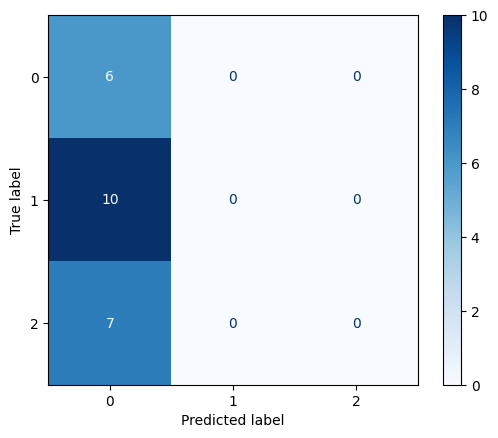

0.2608695652173913

In [14]:
object1.performance(y_test, X_test)

In [15]:
object1.save()

{'optimized_params': [2.41178259200243, 1.0251952065251733, 2.463858827537705, 1.7793292395490798], 'min_loss': np.float64(1.0820571418702354), 'accuracy': 0.2608695652173913, 'all_epochs': array([[ 1.16122825,  0.84815402, 24.10475397],
       [ 1.09111896,  0.84102165, 23.43946528],
       [ 1.11075096,  0.88291116, 24.48528099],
       [ 1.08330459,  0.8853498 , 23.58036613],
       [ 1.08205714,  0.83353388, 23.28819299],
       [ 1.05398429,  0.85699698, 24.19933486],
       [ 1.06405683,  0.94207635, 23.73652601],
       [ 1.00874722,  0.92796664, 23.79727626],
       [ 1.02743443,  0.93667213, 23.70554519],
       [ 1.03264234,  0.89760119, 23.32570791],
       [ 1.01833464,  0.92247607, 24.52000499]])}


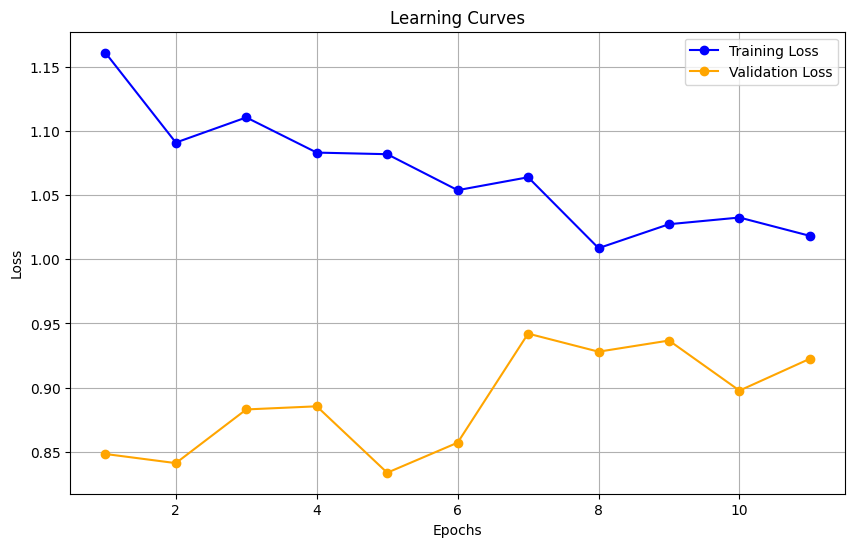

In [18]:
with open ('model_data.pkl', 'rb') as f:
    data = pickle.load(f)

print(data)

import matplotlib.pyplot as plt


def plot_learning_curves(training_loss, validation_loss):
    epochs = range(1, len(training_loss) + 1)
    
    plt.figure(figsize=(10, 6))
    
    #plot training and validation loss over epochs
    plt.plot(epochs, training_loss, label="Training Loss", color="blue", marker='o')
    plt.plot(epochs, validation_loss, label="Validation Loss", color="orange", marker='o')
    
    plt.title("Learning Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

training_loss = object1.all_epochs[:, 0]  # Extract training loss from all_epochs
validation_loss = object1.all_epochs[:, 1]  # Extract validation loss from all_epochs

plot_learning_curves(training_loss, validation_loss)
